# Setup CADET and CADET-Match for Linux (Ubuntu)

The workshop uses Python and not MATLAB for interfacing with CADET.

We will start with creating simple simulations before moving on to some more complex simulations with multiple unit operations. We will then create some simple parameter estimation cases and look at how to make more complex ones. After that we will go over the error model and how and why to use it. Finally I will go over some more advanced models like cyclic models and how to build and work with them. There will be more time to talk about these topics during breaks and in the following days of the workshop.

This document is just to help you get ready for the CADET workshop. If you install everything is this document you will be able to run all the examples in the workshop on your laptop and be ready to use CADET for running further simulations after the workshop. There will be some time to help you install CADET on your computer but that time will be limited during the day. We will also have live Linux installs on USB sticks for everyone to run on your laptops. 

## Create a folder to store all the CADET files

1. In your user directory create a folder CADET [fill in later]

## Download and compile CADET
This documentation is going to assume you are using a Linux distribution related to Ubuntu (Debian). If you install on Fedora or other distributions you will need to adapt the instructions. Making high performance pre-compiled binaries available for Linux us much more difficult and so it needs to be compiled locally. If you have never compiled software before it would be easier to use Windows. This documentation will assume you are generally comfortable with the Linux command line and will focus on the details of getting CADET installed.

Libraries required:

```
HDF5
Sundials
BLAS
LAPACK
TBB
G++
CMake
Git
```

### Enable universe and multiverse for intel-mkl

```
sudo add-apt-repository universe
sudo add-apt-repository multiverse
sudo apt update
```

### Install build tools and libraries

```
sudo apt-get install g++ cmake git curl unzip tar intel-mkl
```

### Install libraries

HDF5 and Sundials in Ubuntu are normally compiled with the right options to work with CADET however this is not always the case. After Anaconda is installed HDF5 is often found from Anaconda instead of the system HDF5. Using VCPKG eliminated this problem entirely.

Microsoft has made a free tool available for finding and installing libraries in a cross-platform way that integrates easily with CMake. This is an easy way to get hdf5 and sundials.You can see the project at https://github.com/microsoft/vcpkg

```
git clone https://github.com/Microsoft/vcpkg.git
cd vcpkg
./bootstrap-vcpkg.sh
./vcpkg integrate install
```

After you run this it will integrate vcpkg so all the libraries can be found. It will also give you a line that looks like

CMake projects should use: "-DCMAKE_TOOLCHAIN_FILE=~/vcpkg/scripts/buildsystems/vcpkg.cmake"

Save this path for later. Your will be a little different base on where your home directory is.

```
./vcpkg install hdf5 sundials
```

## Install CADET

```
git clone https://github.com/modsim/CADET.git
cd CADET
mkdir build
cd build
```

Use the DCMAKE_TOOLCHAIN_FILE you saved up above

```
cmake -DCMAKE_INSTALL_PREFIX="~/cadet" -DBLA_VENDOR=Intel10_64lp_tbb -DCMAKE_TOOLCHAIN_FILE=~/vcpkg/scripts/buildsystems/vcpkg.cmake ..
```

You should see that CADET has found LAPACK, TBB, SUNDIALS and HDF5. 

```
make
make install
```

## Add CADET to your path

```
echo 'export PATH="$HOME/cadet/bin:$PATH"' >> ~/.bashrc
echo 'export LD_LIBRARY_PATH="$HOME/cadet/lib:$LD_LIBRARY_PATH"' >> ~/.bashrc
```

After this logout and login for the changes to take effect.

    
## Install Anaconda

Anaconda is a high-performance scinetific installation of Python that includes many common packages needed for scientific and engineering work. You do not have to use Anaconda but it does make getting all the dependecies much simpler and you don't have to worry about compiling high performance versions of the libraries. 

```
wget https://repo.anaconda.com/archive/Anaconda3-2019.07-Linux-x86_64.sh
chmod u+x Anaconda3-2019.07-Linux-x86_64.sh
./Anaconda3-2019.07-Linux-x86_64.sh
```

You can just accept all the default values.

After this you need to logout and login again so that the changes take effect
    
## Install CADETMatch
### From a terminal window run

The next step is to install CADETMatch. This is the parameter estimation and error modeling software for CADET and it will also automatically pull in the CADET python interface. 

```
pip install CADETMatch
```

### If you are on a network that inteferes with SSL connections you may need to add

```
pip install --trusted-host=pypi.python.org --trusted-host=files.pythonhosted.org --trusted-host=pypi.org CADETMatch
```

## Next enable jupyter notebook extension.

```
conda install -c conda-forge jupyter_contrib_nbextensions
conda install -c conda-forge jupyter_nbextensions_configurator
```

## Start jupyter notebook and enable the following extensions

1. In a terminal window run the following command. After it runs it should open up a browser window.

```
jupyter-notebook
```

2. Click on the Nbextensions tab  
3. Click on the checkbox "disable configuration for nbextensions without explicit compatibility (they may break your notebook environment, but can be useful to show for nbextension development)"
4. Enable Table of Contents 
5. ExecuteTime (shows how long a cell took to run and when it was last run)

# Run the rest of this tutorial locally
At this point you need to download this tutorial and open it with jupyter notebook to completely the tutorial. The rest of the tutorial involves code running on your computer. In the upper right corner there is a download notebook button.

# Verify CADET is working correctly

The next step is to verify that CADET is installed and functioning correctly. To do that download this notebook to your computer. Run the different cells by clicking on the cell and hitting run in the bar or typing shift-enter.

The first step is to import the basic library we need.

In [1]:
#Python path library support
from pathlib import Path

#subprocess allows python to run an external program
import subprocess

#python numeric library
import numpy

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#addict is a library that makes it easier to create nested dictionaries
from addict import Dict

#json is a standard text based format and it used in CADETMatch for the configuration file
import json

#make the plots interactive
%matplotlib inline

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

## Set path to CADET bin folder
The next step is to tell the system where CADET can be found.

This should normally be if you installed it based on the instructions above
>  ~/cadet/bin

In [2]:
#put in the path to the bin folder
cadet_bin_path = Path("/home/kosh/cadet/bin")

cadet_path = cadet_bin_path / "cadet-cli"
lwe_path = cadet_bin_path / "createLWE"

if cadet_path.exists() and lwe_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
elif cadet_path.exists() and not lwe_path.exists():
    print("CADET was found but createLWE.exe was not found. Please make sure that none of the files have been moved.")
else:
    print('CADET could not be found. Please check the bin path')

CADET was found. Continue to the next step.


## Verify CADET is working
CADET comes with some basic tests to verify that it is working correctly. If you install from the zip file this should just automatically work. If it does not please report any error messages you get so we can help fix the problem.

In [4]:
ret = subprocess.run([lwe_path.as_posix()], 
            stdout=subprocess.PIPE, stderr=subprocess.PIPE, cwd=cadet_bin_path.as_posix())
if ret.returncode == 0:
    print("Test simulation was created")
else:
    print("Failure: Creation of test simulation ran into problems")
if ret.stdout:
    print('Output', ret.stdout.decode('utf-8'))
if ret.stderr:
    print('Errors', ret.stderr.decode('utf-8'))
    
lwe_hdf5_path = cadet_bin_path / 'LWE.h5'

#create a simulation
sim = Cadet()

#set the path to where a simulation can be found
sim.filename = lwe_hdf5_path.as_posix()

#run the simulation
data = sim.run()

if data.returncode == 0:
    print("Simulation completed successfully")
else:
    print("Simulation failed")

#Load the data from the simulation
sim.load()

Test simulation was created
Simulation completed successfully


## Plotting the simulation
The next step is to plot the simulation to verify that everything ran correctly. Once you run the next code block you should see 3 curves.

Outlets


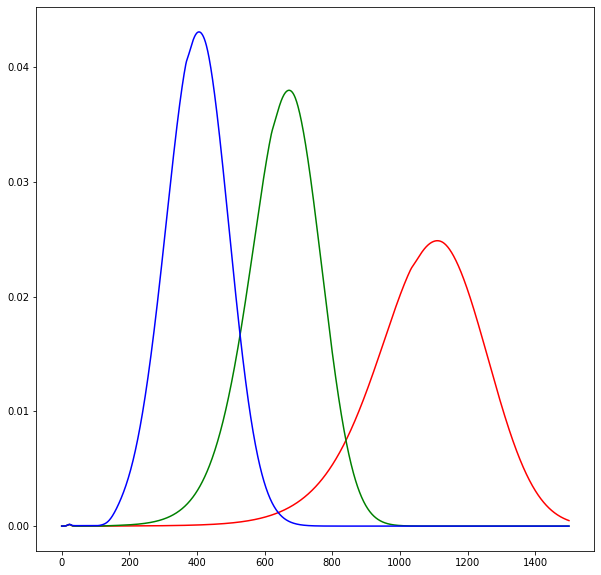

In [5]:
print("Outlets")
plt.figure(figsize=[10,10])
plt.plot(sim.root.output.solution.solution_times,
        sim.root.output.solution.unit_000.solution_outlet_comp_001, color='r')

plt.plot(sim.root.output.solution.solution_times,
        sim.root.output.solution.unit_000.solution_outlet_comp_002, color='g')
        
plt.plot(sim.root.output.solution.solution_times,
        sim.root.output.solution.unit_000.solution_outlet_comp_003, 'b')
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')

## Make some small changes to the simulation
This is to verify that we can write to the file correctly and that parallelization is working.

Simulation completed successfully
Outlets


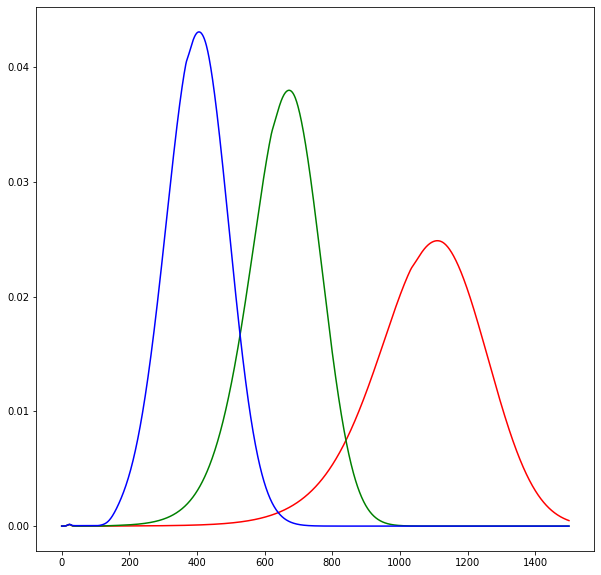

In [6]:
#run simulation in parallel and determine the number of threads automatically
sim.root.input.solver.nthreads = 0

#increase column discretization
sim.root.input.model.unit_001.discretization.ncol = 100

#increase particle discretization
sim.root.input.model.unit_001.discretizationn.npar = 10

sim.save()

data = sim.run()

if data.returncode == 0:
    print("Simulation completed successfully")
else:
    print("Simulation failed")
    
sim.load()

print("Outlets")
plt.figure(figsize=[10,10])
plt.plot(sim.root.output.solution.solution_times,
        sim.root.output.solution.unit_000.solution_outlet_comp_001, color='r')

plt.plot(sim.root.output.solution.solution_times,
        sim.root.output.solution.unit_000.solution_outlet_comp_002, color='g')
        
plt.plot(sim.root.output.solution.solution_times,
        sim.root.output.solution.unit_000.solution_outlet_comp_003, 'b')
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')

# Verify CADETMatch is working
CADETMatch is used for parameter estimation and will be used in the workshop. The example below is a little complex and it will be used with minimal explanation just to verify the software is working. During the workshop we will go over the example in detail.

## Set path
A location needs to be set for CADETMatch to store all the files it needs for running the optimization along with the target simulation and data set.

In [7]:
#set this to a directory on your computer where the example can be saved
match_directory = Path('/home/kosh/example')

col_dispersion = 5.75e-8
col_porosity = 0.37

## Next we create a very simple simulation
This is a simple experiment to find the porosity and axial dispersion of a column by sending a dextran pulse through the column. There will be no binding or pore penetration. The model is created with minimal explanation and will be explored further in the workshop. For now this is just for testing purposes.

You should just be able to run the following cell without changes and it will generate a graph with a simple pulse in it.

Simulation completed successfully


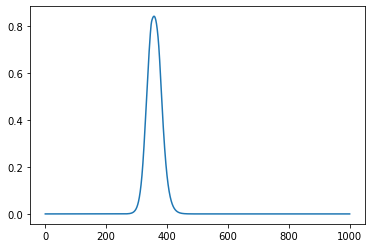

In [8]:
#simple model

simple = Cadet()
simple.filename = (match_directory / 'example.h5').as_posix()

#basic solver settings, these values should rarely be changed
simple.root.input.model.solver.gs_type = 1
simple.root.input.model.solver.max_krylov = 0
simple.root.input.model.solver.max_restarts = 10
simple.root.input.model.solver.schur_safety  = 1e-8

#setup unit operations and connect them together
simple.root.input.model.nunits = 3
simple.root.input.model.connections.nswitches = 1
simple.root.input.model.connections.switch_000.section = 0

#this connects unit 0 to unit 1 and unit 1 to unit 2 with 2.88e-8 m^3/s with all components
simple.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, 2.88e-8,
                                                              1, 2, -1, -1, 2.88e-8]

#create an inlet
simple.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'
simple.root.input.model.unit_000.unit_type = 'INLET'
simple.root.input.model.unit_000.ncomp = 1

simple.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
simple.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
simple.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
simple.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

simple.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
simple.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
simple.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
simple.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

#create a column
simple.root.input.model.unit_001.adsorption_model = 'NONE'
simple.root.input.model.unit_001.col_dispersion = col_dispersion
simple.root.input.model.unit_001.col_length = 0.25
simple.root.input.model.unit_001.col_porosity = col_porosity
simple.root.input.model.unit_001.film_diffusion = [0.0,]
simple.root.input.model.unit_001.init_c = [0.0,]
simple.root.input.model.unit_001.init_q = [0.0,]
simple.root.input.model.unit_001.ncomp = 1
simple.root.input.model.unit_001.par_diffusion = [7e-9,]
simple.root.input.model.unit_001.par_porosity = 0.33
simple.root.input.model.unit_001.par_radius = 4.5e-5
simple.root.input.model.unit_001.par_surfdiffusion = [0.0,]
simple.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITH_PORES'

simple.root.input.model.unit_001.velocity = 1
simple.root.input.model.unit_001.cross_section_area = 1.0386890710931253E-4

#discretization column settings
simple.root.input.model.unit_001.discretization.nbound = [0,]
simple.root.input.model.unit_001.discretization.ncol = 40
simple.root.input.model.unit_001.discretization.par_disc_type = 'EQUIDISTANT_PAR'
simple.root.input.model.unit_001.discretization.schur_safety = 1.0e-8
simple.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
simple.root.input.model.unit_001.discretization.weno.boundary_model = 0
simple.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
simple.root.input.model.unit_001.discretization.weno.weno_order = 3
simple.root.input.model.unit_001.discretization.gs_type = 1
simple.root.input.model.unit_001.discretization.max_krylov = 0
simple.root.input.model.unit_001.discretization.max_restarts = 10

#create an outlet
simple.root.input.model.unit_002.ncomp = 1
simple.root.input.model.unit_002.unit_type = 'OUTLET'

#solver settings
simple.root.input.solver.user_solution_times = numpy.linspace(0, 1000, 10001)
simple.root.input.solver.sections.nsec = 2
simple.root.input.solver.sections.section_continuity = [0,]
simple.root.input.solver.sections.section_times = [0.0, 50.0, 1000.0]

simple.root.input.solver.time_integrator.abstol = 1e-10
simple.root.input.solver.time_integrator.algtol = 1e-12
simple.root.input.solver.time_integrator.init_step_size = 1e-6
simple.root.input.solver.time_integrator.max_steps = 1000000
simple.root.input.solver.time_integrator.reltol = 1e-10

#automatically run the simulation in parallel
simple.root.input.solver.nthreads = 0

#set what data cadet returns after running the simulation
simple.root.input['return'].write_solution_times = 1
simple.root.input['return'].split_components_data = 1
simple.root.input['return'].unit_000.write_sens_bulk = 0
simple.root.input['return'].unit_000.write_sens_flux = 0
simple.root.input['return'].unit_000.write_sens_inlet = 1
simple.root.input['return'].unit_000.write_sens_outlet = 1
simple.root.input['return'].unit_000.write_sens_particle = 0
simple.root.input['return'].unit_000.write_solution_bulk = 0
simple.root.input['return'].unit_000.write_solution_flux = 0
simple.root.input['return'].unit_000.write_solution_inlet = 1
simple.root.input['return'].unit_000.write_solution_outlet = 1
simple.root.input['return'].unit_000.write_solution_particle = 0

simple.root.input['return'].unit_001 = simple.root.input['return'].unit_000
simple.root.input['return'].unit_002 = simple.root.input['return'].unit_000

simple.save()
data = simple.run()
if data.returncode == 0:
    print("Simulation completed successfully")
    
    simple.load()

    plt.plot(simple.root.output.solution.solution_times,
        simple.root.output.solution.unit_001.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    data = pandas.DataFrame([simple.root.output.solution.solution_times,
                        simple.root.output.solution.unit_001.solution_outlet_comp_000]).transpose()
    data.to_csv((match_directory / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Setup match configuration
CADETMatch uses a JSON file to specify the problem for parameter estimation and error modeling. Normally this file is just created and edited in a simple text editor. For the purpose of this demonstration the file is going to be created in Python and then written out as a JSON file.

In [9]:
match = Dict()
match.CADETPath = cadet_path.as_posix()
match.baseDir = match_directory.as_posix()
match.resultsDir = 'fit'
match.CSV = 'fit_results.csv'
match.checkpointFile = "check"
match.stopAverage = 1.1
match.stopBest = 1.1
match.gradCheck = 1.1
match.gradVector = 1
match.searchMethod = 'NSGA3_deap'
match.mutationRate = 1.0
match.crossoverRate = 1.0
match.generations = 1000
match.population = 12
match.minPopulation = 12
match.maxPopulation = 12
match.finalGradRefinement = 1
match.stallGenerations = 10

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.2
parameter2.max = 0.5

match.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.CSV = "example.csv"
experiment1.isotherm = "/output/solution/unit_001/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

match.experiments = [experiment1,]

match_file = match_directory / 'example.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Import CADETMatch jupyter notebook interface
The CADETMatch jupyter notebook interface is good for simple testing and running simulations locally. The interface is limited. The full dataset can be found on your drive along with information about identifiable parameters, how well the optimization proceeded and other information.

In [10]:
from CADETMatch.jupyter import Match

## Create a matching session
The next part is to create an object that will run CADETMatch along with holding and processing results. CADETMatch uses a JSON formatted configuration file.

In [11]:
sim = Match((match_directory / 'example.json').as_posix())

## Clearing parameter estimation directory
If you want to delete the parameter estimation fit to restart the fit from scratch you can uncomment the last line in the next cell and run the cell. You can do this if you just want to run the fit again with different settings to see what impact different settings have or if you change the simulation and want to see what happens as a result. 

If you change settings and re-run the fit without deleting the directory it writes to the fit will try to resume from where it left off which won't have the desired result.

In [12]:
resultDir = Path(match.baseDir) / match.resultsDir
print("Your results are located at", resultDir.as_posix())

def deleteResultDir(path):
    #This is to try and make sure that only an actual result directory can be removed
    #And only if no other files have been added to the directory, just in case
    allowed = {'evo', 'grad', 'log', 'mcmc', 'meta', 'misc', 'progress', 
               'space', 'error.csv', 'result.h5', 'progress.csv'}
    allowed.add(match.CSV)
    allowed.add(match_file.name)
    okayToRemove = False
    for child in path.iterdir():
        if child.name not in allowed:
            break
    else:
        okayToRemove = True
    if okayToRemove:
        import shutil
        shutil.rmtree(path)

#If you want to delete the fitting process to start over remove the # from the next line and re-run this cell
#deleteResultDir(resultDir)

Your results are located at /home/kosh/example/fit


## Start parameter estimation
After the matching process has been setup you need to tell the system to go ahead and run the match. If you have a match that has already been run you can setup the simulation and go directly to processing the data. If you have a simulation that is incomplete and you run this code again the matching process will resume close to where it left off.

This will probably take 5-15 minutes to run depending on how powerful your laptop is.

If you want to completly restart the matching process you will need to delete the directory created or the system will just try to resume from the last run. 

In [13]:
sim.start_sim()

[2019-09-25 12:38:53,152] launcher  INFO    SCOOP 0.7 1.1 on linux using Python 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0], API: 1013

[2019-09-25 12:38:53,152] launcher  INFO    Deploying 6 worker(s) over 1 host(s).

[2019-09-25 12:38:53,152] launcher  INFO    Worker distribution: 

[2019-09-25 12:38:53,152] launcher  INFO       127.0.0.1:	5 + origin

[2019-09-25 12:38:59,494] util      (b'127.0.0.1:60310') INFO    Generation: -1 	Population: 24 	Average Score: 0.988 	Best: 0.996 	Minimum Score: 0.98 	Best: 0.992 	Product Score: 0.988 	Best: 0.996

[2019-09-25 12:39:04,384] gradFD    (b'127.0.0.1:60310') INFO    overlap restriction not necessary

[2019-09-25 12:39:04,404] util      (b'127.0.0.1:60310') INFO    Generation: 0 	Population: 24 	Average Score: 0.997 	Best: 0.999 	Minimum Score: 0.993 	Best: 0.999 	Product Score: 0.997 	Best: 0.999

[2019-09-25 12:39:09,624] gradFD    (b'127.0.0.1:60310') INFO    overlap restriction not necessary

[2019-09-25 12:39:09,644] util     

0

## Plotting results

### Corner plots
For parameter estimation what you are looking for in corner plots is a single unique peak. The more narrow the peak the more identifiable the parameter. The actual distributions are not statistically correct but these kinds of plots are a good qualitative way to judge if your experiments are working. Also, just because a parameter is not identifiable does not mean the parameter is not important. It just means that given the data you gave to the matching software that no single value can be determined. To address this you either need more experiments, different experiments or to just choose a value for the parameter depending on the parameter. We will go over this in more detail in the workshop.

Corner plot in search space


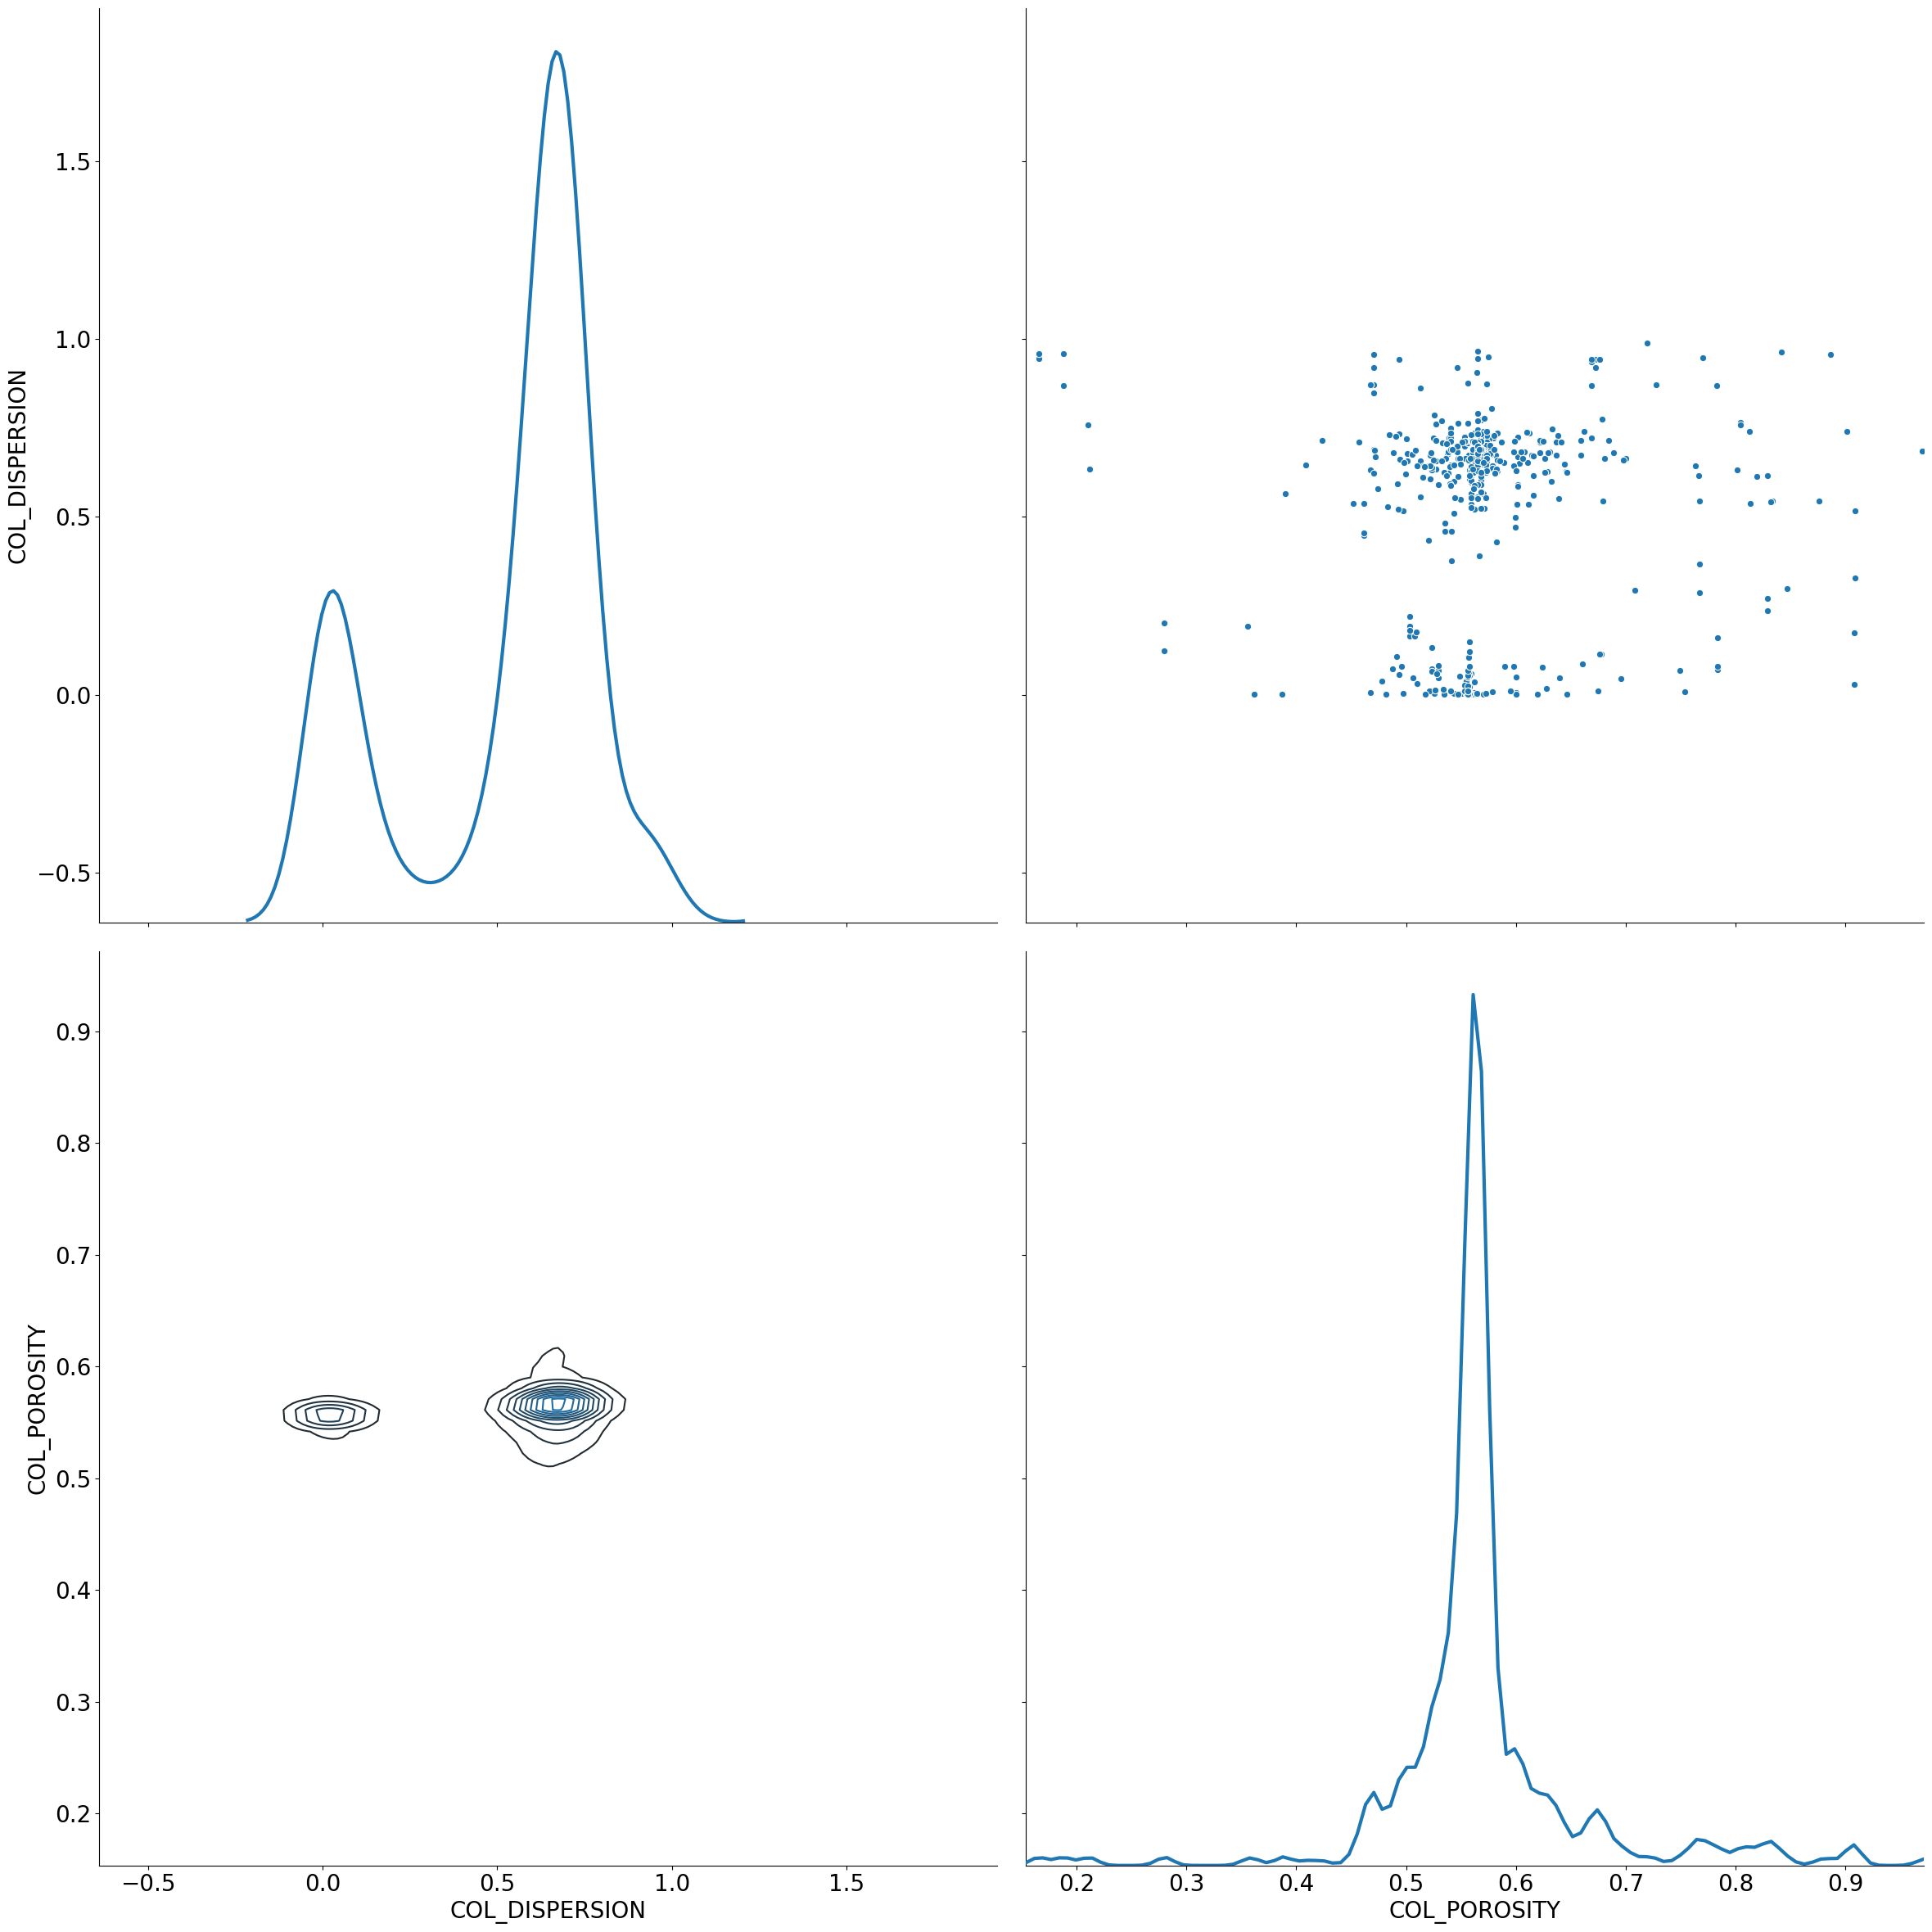

Corner plot in original space


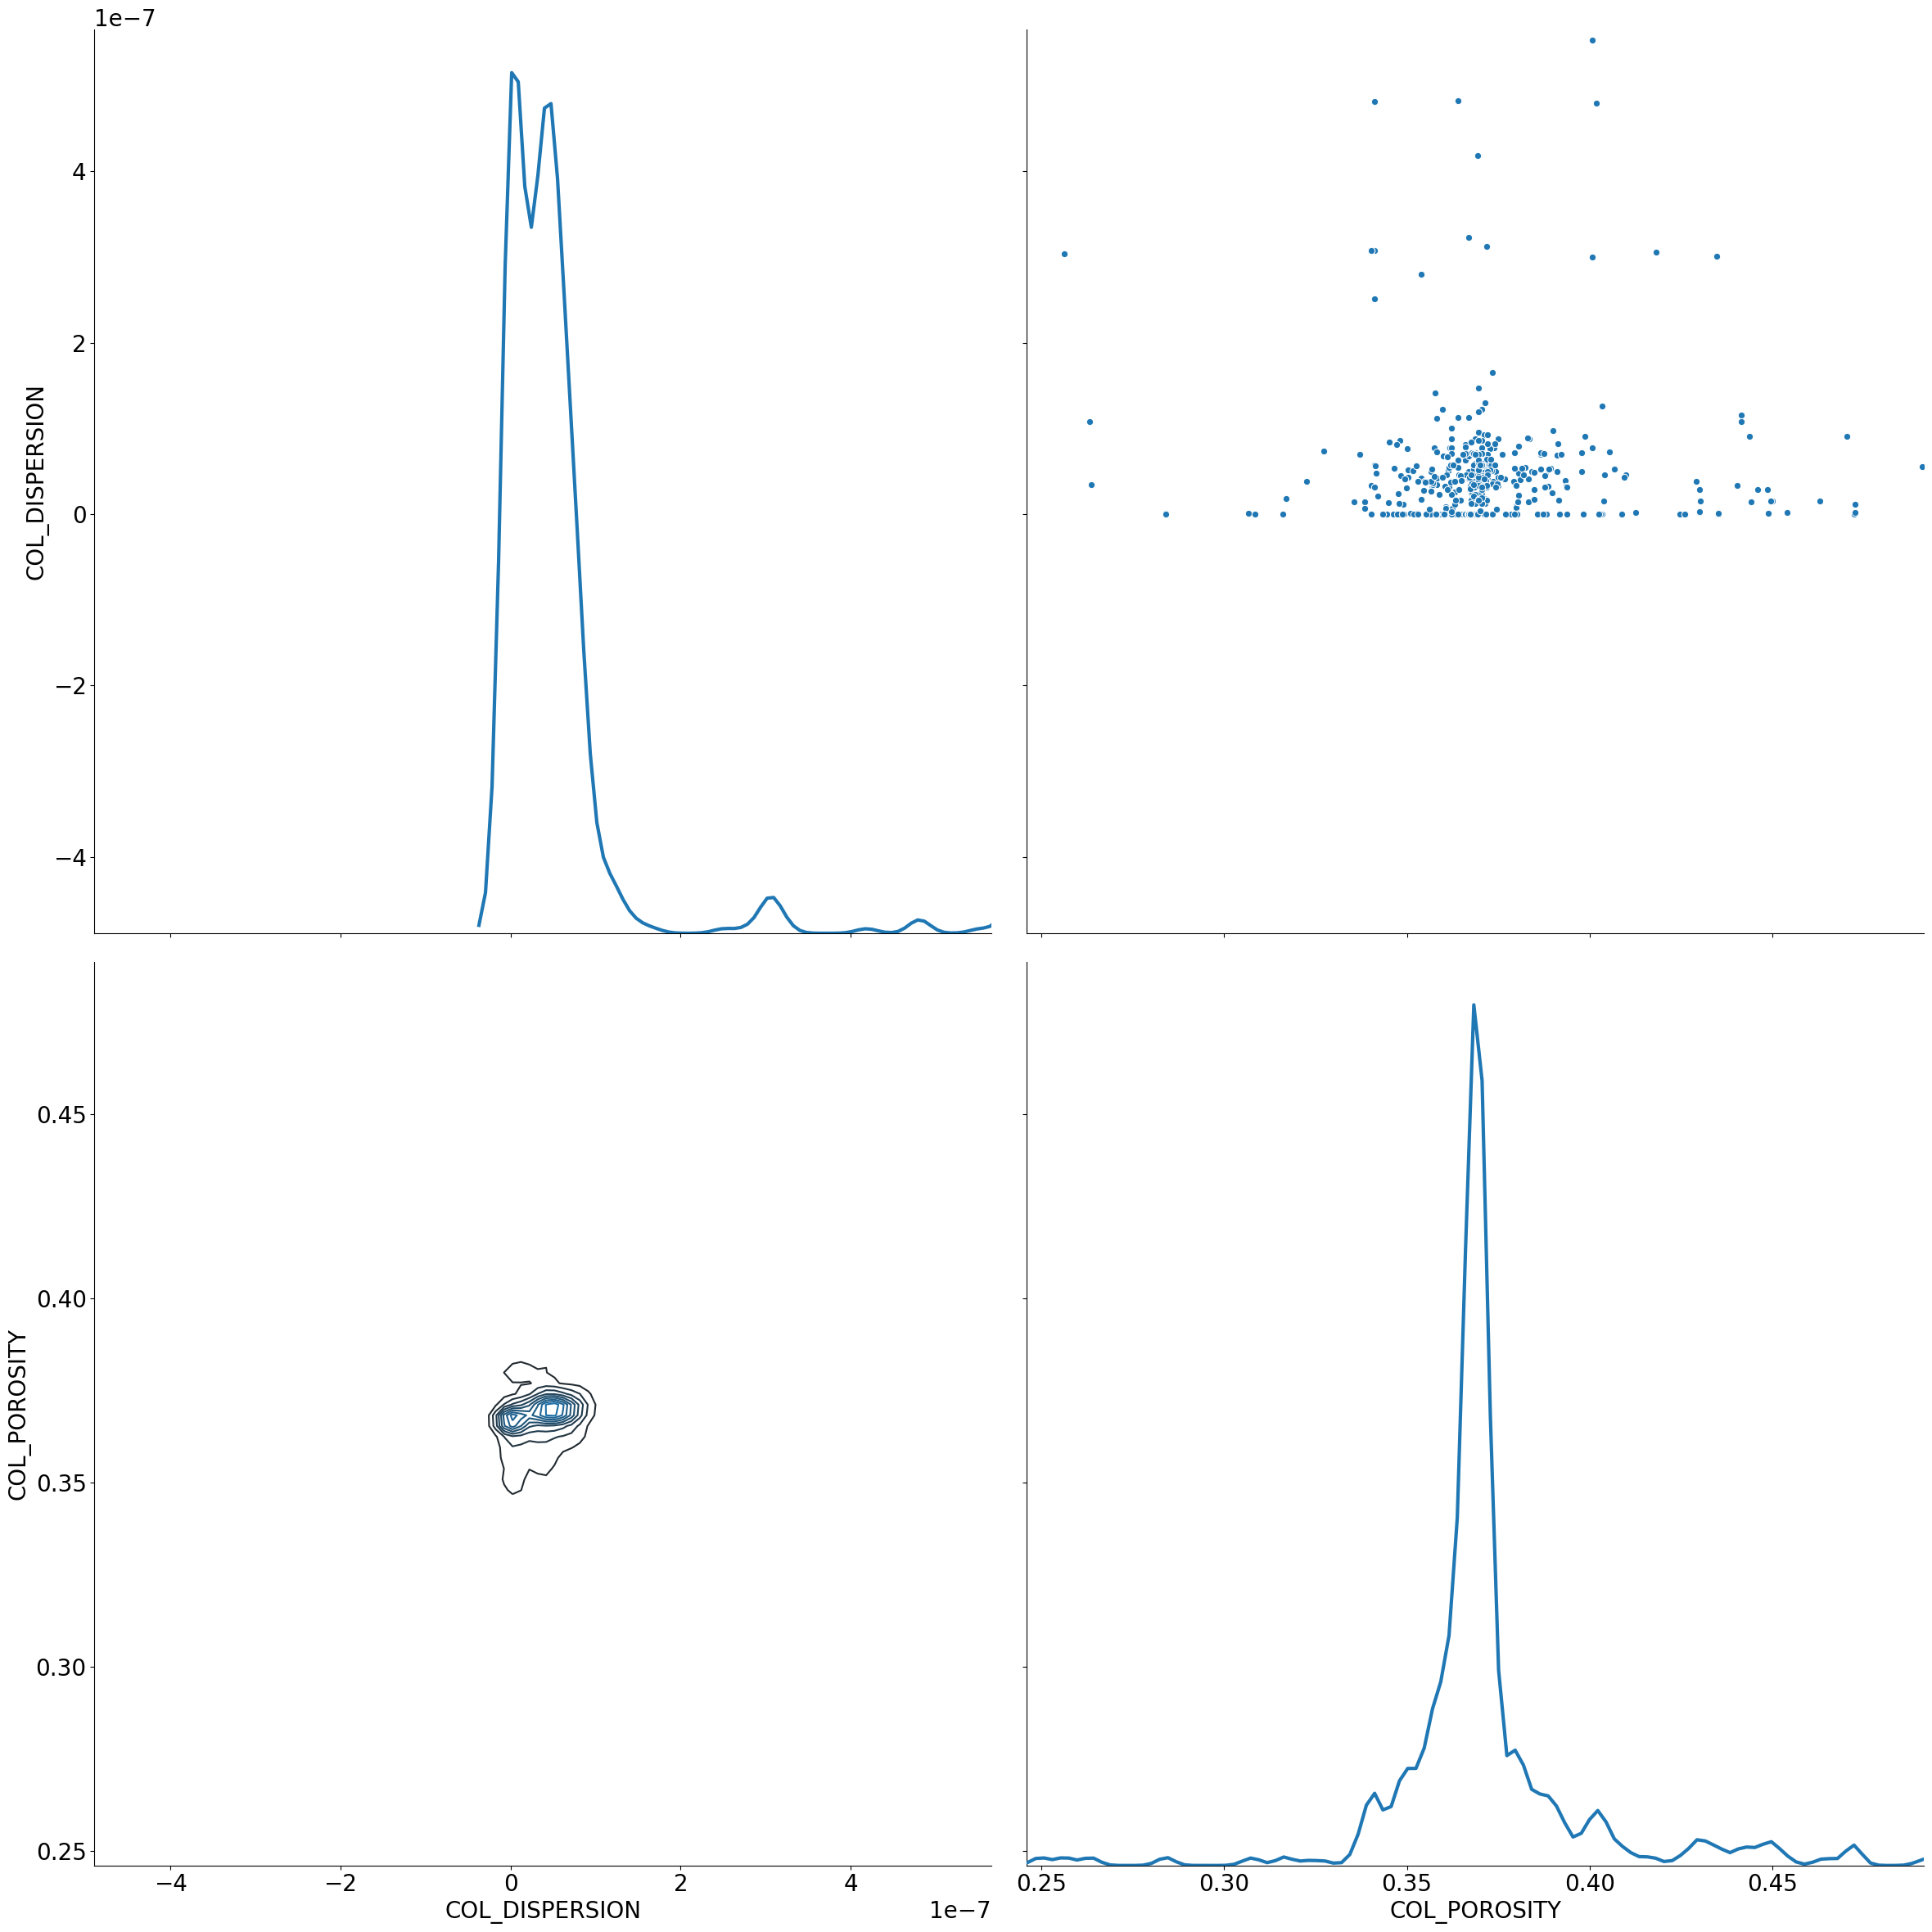

In [14]:
sim.plot_corner()

### Best plots
The next set of plots shows the best result for each of the meta metrics. It shows the ID of the best item, by what measures it is the best result and also the values found along with how good the result was for each measurement. The meta metrics will be explained in the workshop. For now you can look at see how good the fit is.

Best item fa40641887a1d0874451ac83ca5cf2a3 for meta score(s) Product Root Score , Min Score , Mean Score , SSE


Time                              Name Method  \
0  Wed Sep 25 12:41:13 2019  fa40641887a1d0874451ac83ca5cf2a3   GRAD   

   Condition Number  COL_DISPERSION Comp:-1 Bound:-1  \
0               NaN                     5.729664e-08   

   COL_POROSITY Comp:-1 Bound:-1  main_Pulse_Shape  main_Pulse_Time  \
0                       0.369989               1.0              1.0   

   Product Root Score  Min Score  Mean Score           SSE  
0                 1.0        1.0         1.0  3.256537e-10

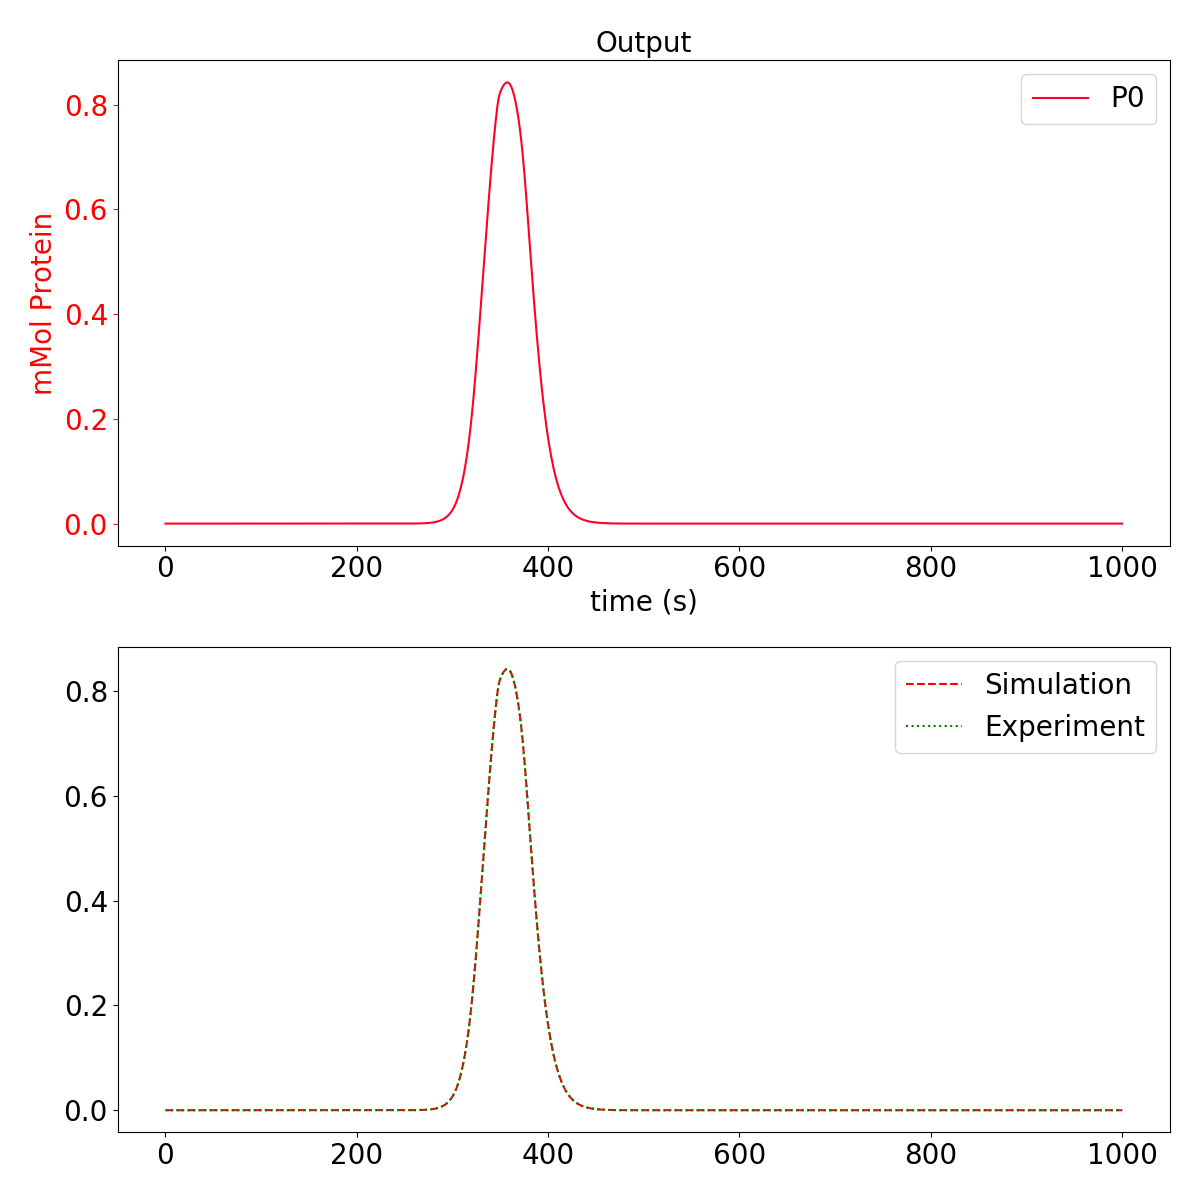

In [15]:
sim.plot_best()

## Simulation error
Since this is a synthetic simulation we can look at how accurate the parameter estimation is. Since we know what the correct answer is we can compare to the results of parameter estimation.

Since this example is just here to verify if the software is working correctly and terminates quickly it is possible that the errors could be quite large. This is normal.

In [16]:
best ,score, best_score = sim.get_best()
true_values = numpy.array([col_dispersion, col_porosity])
for key,value in best_score.items():
    print("Method: %s" % key)
    for name, val, true_value in zip(sim.cache.parameter_headers, value, true_values):
        print("%s = %.2e   error: %.2g%%" % (name, val, numpy.abs(val-true_value)/val*100))
    print('\n')

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 5.73e-08   error: 0.35%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.003%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 5.73e-08   error: 0.35%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.003%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 5.73e-08   error: 0.35%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.003%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 5.73e-08   error: 0.35%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01   error: 0.003%


